# Pole Compilation

In [1]:
# standard modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

# pmagpy
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

Functions:

In [2]:
def plot_dates(zircon_means, zircon_2sigmas, include, sample_means, sample_2sigmas, colours, labels,\
               legend=True, figsize=None, ylim=None, lineweight=None, bbox_to_anchor=None, mean_box=None):
    """
    Make a date distribution plot.
    
    Parameters
    ----------
    zircon_means : list of numpy arrays
        individual zircon mean dates (each array being a sample, and each element of that array being a zircon)
    
    zircon_2sigmas : list of numpy arrays
        individual zircon 2 sigmas (each array being a sample, and each element of that array being a zircon)
        
    include : list of lists
        'yes' or 'no' for inclusion of individual zircon in mean (each array being a sample, and each element of
        that array being a zircon)
        
    sample_means : list
        sample mean dates (each element being a sample)
        
    sample_2sigmas : list
        sample 2 sigmas (each element being a sample)
        
    colours : list
        sample colours for plotting (each element being a sample)
        
    labels : list
        sample labels for the legend (each element being a sample)
        
    legend : boolean
        if True, plot legend (default True, optional)
        
    figsize : tuple
        figure size (default None, optional)
        
    ylim : tuple
        figure y limits (default None, optional)
        
    lineweight : float
        line weight for individual zircons (default None, optional)
        
    bbox_to_anchor : tuple
        for manual placement of the legend (default None, optional)
        
    mean_box : list
        booleans, for decided whether to draw the mean and 2 sigma for a sample (default None, optional)
        
    Returns
    -------
    fig : figure handle
    
    ax : axis handle
    """
    # formatting constants
    zircon_spacing = 1
    sample_spacing = 6 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    # iterate over each sample
    plot_mean_box = False
    for i in range(n_samples):
        
        # number of zircons in sample
        n_zircons = len(zircon_means[i])
        
        # check if we need to plot the mean box
        if mean_box==None:
            plot_mean_box = True
        elif mean_box[i]:
            plot_mean_box = True
        
        # iterate over each zircon to find the mean box coordinates
        if plot_mean_box:
            start_box = False
            end_box = False
            for j in range(n_zircons):
                if include[i][j] == 'yes' and start_box == False:
                    start_box_x = current_x + j*zircon_spacing - zircon_spacing/2
                    start_box = True
                if include[i][j] == 'no' and start_box == True and end_box == False:
                    end_box_x = current_x + (j-1)*zircon_spacing + zircon_spacing/2
                    end_box = True
            if end_box == False:
                end_box_x = current_x + (n_zircons-1)*zircon_spacing + zircon_spacing/2

            # plot the mean box
            # the 2sigma uncertainty on the sample age
            if sample_2sigmas != None:
                rectangle = matplotlib.patches.Rectangle((start_box_x, sample_means[i]-sample_2sigmas[i]),
                                                         (end_box_x-start_box_x), sample_2sigmas[i]*2, color='C7')
                ax.add_patch(rectangle)

            # the mean age
            if sample_means != None:
                ax.hlines(sample_means[i], start_box_x, end_box_x)
        
        # iterate over each zircon to plot the zircons
        marked = False # legend control
        for j in range(n_zircons):
            
            if marked:
                if include[i][j] == 'yes':
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=yes_alpha)
                else:
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
            else:
                if include[i][j] == 'yes':
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                    marked = True
                else:
                    ax.vlines(current_x,
                              zircon_means[i][j]-zircon_2sigmas[i][j],
                              zircon_means[i][j]+zircon_2sigmas[i][j],
                              colors=colours[i], lw=lineweight, alpha=no_alpha)
                
            # tick the x to the next zircon
            current_x = current_x + zircon_spacing
        
        # tick the x to the next sample
        current_x = current_x + sample_spacing
        
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date [Ma]')
    if legend:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax

## South China

Set up compilation dataframe:

In [3]:
compiled_cols = ['age',
                 'age upper (reported)',
                 'age lower (reported)',
                 'age upper (estimate)',
                 'age lower (estimate)',
                 'lat',
                 'lon',
                 'a95',
                 'rock',
                 'f',
                 'pole reference',
                 'age reference',
                 'grade',
                 'note']

SChina_compiled = pd.DataFrame(columns=compiled_cols)

j = 0

### Yanbian Dikes

The individual zircon measurements from Table 1 in Niu et al. (2016), dike 09YBD03:

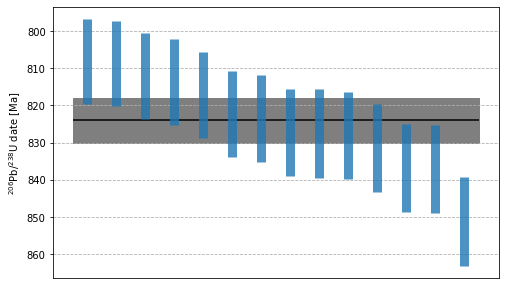

In [4]:
Yanbian_means = np.array([813.7,808.7,831.5,823.6,817.1,827.3,822.3,836.8,828.1,827.5,812.1,851.2,808.1,837.2])
Yanbian_1sigmas = np.array([11.5,11.4,11.8,11.7,11.6,11.7,11.6,11.8,11.7,11.9,11.6,12.0,11.4,11.8])
Yanbian_include = [['yes'] * len(Yanbian_means)]
Yanbian_sample_mean = [824]
Yanbian_sample_1sigma = [6]
Yanbian_colors = ['C0']
Yanbian_labels = ['Yanbian Dike 09YBD03']

# sort
Yanbian_means_argsort = np.argsort(Yanbian_means)
Yanbian_means = [Yanbian_means[Yanbian_means_argsort]]
Yanbian_1sigmas = [Yanbian_1sigmas[Yanbian_means_argsort]]

fig, ax = plot_dates(Yanbian_means,
                     Yanbian_1sigmas,
                     Yanbian_include,
                     Yanbian_sample_mean,
                     Yanbian_sample_1sigma,
                     Yanbian_colors,
                     Yanbian_labels,
                     legend=False, lineweight=9, figsize=(8,5), mean_box=[True])
ax.set_xticks([])
ax.grid(axis='y', ls='--')
plt.show(fig)

In [5]:
SChina_compiled.loc[j, 'age'] = 824
SChina_compiled.loc[j, 'age upper (reported)'] = 824 - 6
SChina_compiled.loc[j, 'age lower (reported)'] = 824 + 6
SChina_compiled.loc[j, 'age upper (estimate)'] = 800
SChina_compiled.loc[j, 'age lower (estimate)'] = 860
SChina_compiled.loc[j, 'lat'] = 45.1
SChina_compiled.loc[j, 'lon'] = 130.4
SChina_compiled.loc[j, 'a95'] = 19.0
SChina_compiled.loc[j, 'rock'] = 'Yanbian Dikes Group A - mafic dikes'
SChina_compiled.loc[j, 'f'] = 0
SChina_compiled.loc[j, 'pole reference'] = 'Niu et al. (2016)'
SChina_compiled.loc[j, 'age reference'] = 'Niu et al. (2016) - SIMS on dike'
SChina_compiled.loc[j, 'grade'] = 'B - baked contact test, dike-tilt test, rock magnetism'
SChina_compiled.loc[j, 'note'] = 'A 5 degree vertical axis rotation is applied to these data in the paper. They are not tilt-corrected (except for one) although they are located within a mobile belt.'
j = j + 1

### Madiyi Formation:

The individual zircon measurements from Table S1 in Xian et al. (2020), tuff ZJ-B:

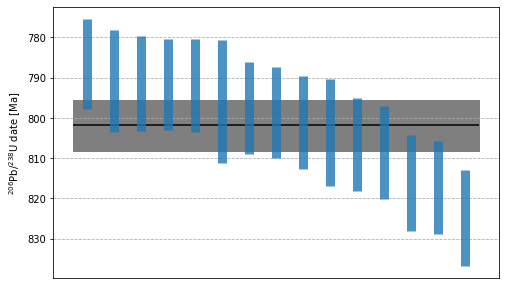

In [6]:
Madiyi_means = np.array([806.6,791.5,797.6,824.9,791.9,817.3,816.2,803.6,786.6,801.2,798.7,808.6,791.7,795.9,790.8])
Madiyi_1sigmas = np.array([11.5,11.8,11.5,11.9,11.5,11.6,11.9,13.3,11.2,11.6,11.3,11.6,11.2,15.2,12.7])
Madiyi_include = [['yes'] * len(Madiyi_means)]
Madiyi_sample_mean = [801.9]
Madiyi_sample_1sigma = [6.3]
Madiyi_colors = ['C0']
Madiyi_labels = ['Madiyi Formation tuff ZJ-B']

# sort
Madiyi_means_argsort = np.argsort(Madiyi_means)
Madiyi_means = [Madiyi_means[Madiyi_means_argsort]]
Madiyi_1sigmas = [Madiyi_1sigmas[Madiyi_means_argsort]]

fig, ax = plot_dates(Madiyi_means,
                     Madiyi_1sigmas,
                     Madiyi_include,
                     Madiyi_sample_mean,
                     Madiyi_sample_1sigma,
                     Madiyi_colors,
                     Madiyi_labels,
                     legend=False, lineweight=9, figsize=(8,5), mean_box=[True])
ax.set_xticks([])
ax.grid(axis='y', ls='--')
plt.show(fig)

In [7]:
SChina_compiled.loc[j, 'age'] = 801.9
SChina_compiled.loc[j, 'age upper (reported)'] = 801.9 - 6.3
SChina_compiled.loc[j, 'age lower (reported)'] = 801.9 + 6.3
SChina_compiled.loc[j, 'age upper (estimate)'] = 780
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = 35.3
SChina_compiled.loc[j, 'lon'] = 67.9
SChina_compiled.loc[j, 'a95'] = np.sqrt(4.7*5.5)
SChina_compiled.loc[j, 'rock'] = 'Madiyi Formation - mudstone'
SChina_compiled.loc[j, 'f'] = 0
SChina_compiled.loc[j, 'pole reference'] = 'Xian et al. (2020)'
SChina_compiled.loc[j, 'age reference'] = 'Xian et al. (2020) - SIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - reversal test'
SChina_compiled.loc[j, 'note'] = 'Inclination correction preferred by authors.'
j = j + 1

In [8]:
SChina_compiled.loc[j, 'age'] = 801.9
SChina_compiled.loc[j, 'age upper (reported)'] = 801.9 - 6.3
SChina_compiled.loc[j, 'age lower (reported)'] = 801.9 + 6.3
SChina_compiled.loc[j, 'age upper (estimate)'] = 780
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = 34.3
SChina_compiled.loc[j, 'lon'] = 82.4
SChina_compiled.loc[j, 'a95'] = np.sqrt(3.9*3.7)
SChina_compiled.loc[j, 'rock'] = 'Madiyi Formation - mudstone'
SChina_compiled.loc[j, 'f'] = 0.6
SChina_compiled.loc[j, 'pole reference'] = 'Xian et al. (2020)'
SChina_compiled.loc[j, 'age reference'] = 'Xian et al. (2020) - SIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - reversal test'
SChina_compiled.loc[j, 'note'] = 'Inclination correction preferred by authors.'
j = j + 1

### Chengjiang Formation

Currently no access to the individual zircon measurements. However, based on Fig. 7 of Jing et al. (2019), we can assign an estimated uncertainty:

In [9]:
SChina_compiled.loc[j, 'age'] = 799.5
SChina_compiled.loc[j, 'age upper (reported)'] = 799.5 - 8.4
SChina_compiled.loc[j, 'age lower (reported)'] = 799.5 + 8.4
SChina_compiled.loc[j, 'age upper (estimate)'] = 770
SChina_compiled.loc[j, 'age lower (estimate)'] = 830
SChina_compiled.loc[j, 'lat'] = 33.4
SChina_compiled.loc[j, 'lon'] = 56.1
SChina_compiled.loc[j, 'a95'] = np.sqrt(7.3*8.9)
SChina_compiled.loc[j, 'rock'] = 'Chengjiang Formation - sandstone'
SChina_compiled.loc[j, 'f'] = 0
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2019)'
SChina_compiled.loc[j, 'age reference'] = 'Jing et al. (2019) - SIMS on tuffaceous siltstone'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = '-'
j = j + 1

### Liantuo Formation

Age is preliminary:

In [10]:
SChina_compiled.loc[j, 'age'] = 788
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 13.2
SChina_compiled.loc[j, 'lon'] = 155.2
SChina_compiled.loc[j, 'a95'] = 5.3
SChina_compiled.loc[j, 'rock'] = 'Liantuo Formation - siltstone-sandstone'
SChina_compiled.loc[j, 'f'] = 0
SChina_compiled.loc[j, 'pole reference'] = 'Jing et al. (2015)'
SChina_compiled.loc[j, 'age reference'] = 'redated preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test'
SChina_compiled.loc[j, 'note'] = 'Grand mean pole of Evans et al. (2000) and Jing et al. (2015).'
j = j + 1

### Banxi Group

Age is preliminary:

In [11]:
SChina_compiled.loc[j, 'age'] = 815
SChina_compiled.loc[j, 'age upper (reported)'] = np.nan
SChina_compiled.loc[j, 'age lower (reported)'] = np.nan
SChina_compiled.loc[j, 'age upper (estimate)'] = np.nan
SChina_compiled.loc[j, 'age lower (estimate)'] = np.nan
SChina_compiled.loc[j, 'lat'] = 51.6
SChina_compiled.loc[j, 'lon'] = 90.5
SChina_compiled.loc[j, 'a95'] = np.sqrt(13.8*15.1)
SChina_compiled.loc[j, 'rock'] = 'Banxi Group - siltstone'
SChina_compiled.loc[j, 'f'] = 0
SChina_compiled.loc[j, 'pole reference'] = 'preliminary results'
SChina_compiled.loc[j, 'age reference'] = 'preliminary results - TIMS on tuff'
SChina_compiled.loc[j, 'grade'] = 'n/a - fold test, reversal test'
SChina_compiled.loc[j, 'note'] = '-'
j = j + 1

### Xiaofeng Dikes

In [12]:
SChina_compiled.loc[j, 'age'] = 821
SChina_compiled.loc[j, 'age upper (reported)'] = 821.10 - 0.2
SChina_compiled.loc[j, 'age lower (reported)'] = 821.64 + 0.2
SChina_compiled.loc[j, 'age upper (estimate)'] = 821.10 - 0.2
SChina_compiled.loc[j, 'age lower (estimate)'] = 821.64 + 0.2
SChina_compiled.loc[j, 'lat'] = 13.5
SChina_compiled.loc[j, 'lon'] = 91.0
SChina_compiled.loc[j, 'a95'] = np.sqrt(10.5*11.3)
SChina_compiled.loc[j, 'rock'] = 'Xiaofeng Dikes - mafic dikes'
SChina_compiled.loc[j, 'f'] = 0
SChina_compiled.loc[j, 'pole reference'] = 'Li et al. (2004)'
SChina_compiled.loc[j, 'age reference'] = 'Wang et al. (2016) - TIMS on tuffs'
SChina_compiled.loc[j, 'grade'] = 'B - reversal test, regional geology'
SChina_compiled.loc[j, 'note'] = '-'
j = j + 1

### Compiled

In [13]:
SChina_compiled.sort_values('age', inplace=True)
SChina_compiled = SChina_compiled[compiled_cols]
SChina_compiled.reset_index(inplace=True, drop=True)
SChina_compiled

,age,age upper (reported),age lower (reported),age upper (estimate),age lower (estimate),lat,lon,a95,rock,f,pole reference,age reference,grade,note
0,788,NaN,NaN,NaN,NaN,13.2,155.2,5.3,Liantuo Formation - siltstone-sandstone,0,Jing et al. (2015),redated preliminary results - TIMS on tuff,B - reversal test,Grand mean pole of Evans et al. (2000) and Jin...
1,799.5,791.1,807.9,770,830,33.4,56.1,8.0604,Chengjiang Formation - sandstone,0,Jing et al. (2019),Jing et al. (2019) - SIMS on tuffaceous siltstone,"n/a - fold test, reversal test",-
2,801.9,795.6,808.2,780,830,35.3,67.9,5.08429,Madiyi Formation - mudstone,0,Xian et al. (2020),Xian et al. (2020) - SIMS on tuff,n/a - reversal test,Inclination correction preferred by authors.
3,801.9,795.6,808.2,780,830,34.3,82.4,3.79868,Madiyi Formation - mudstone,0.6,Xian et al. (2020),Xian et al. (2020) - SIMS on tuff,n/a - reversal test,Inclination correction preferred by authors.
4,815,NaN,NaN,NaN,NaN,51.6,90.5,14.4354,Banxi Group - siltstone,0,preliminary results,preliminary results - TIMS on tuff,"n/a - fold test, reversal test",-
5,821,820.9,821.84,820.9,821.84,13.5,91,10.8927,Xiaofeng Dikes - mafic dikes,0,Li et al. (2004),Wang et al. (2016) - TIMS on tuffs,"B - reversal test, regional geology",-
6,824,818,830,800,860,45.1,130.4,19,Yanbian Dikes Group A - mafic dikes,0,Niu et al. (2016),Niu et al. (2016) - SIMS on dike,"B - baked contact test, dike-tilt test, rock m...",A 5 degree vertical axis rotation is applied t...


Don't use inclination correction for now:

In [14]:
SChina_compiled = SChina_compiled[SChina_compiled['f']==0]
SChina_compiled.reset_index(inplace=True, drop=True)
SChina_compiled

,age,age upper (reported),age lower (reported),age upper (estimate),age lower (estimate),lat,lon,a95,rock,f,pole reference,age reference,grade,note
0,788,NaN,NaN,NaN,NaN,13.2,155.2,5.3,Liantuo Formation - siltstone-sandstone,0,Jing et al. (2015),redated preliminary results - TIMS on tuff,B - reversal test,Grand mean pole of Evans et al. (2000) and Jin...
1,799.5,791.1,807.9,770,830,33.4,56.1,8.0604,Chengjiang Formation - sandstone,0,Jing et al. (2019),Jing et al. (2019) - SIMS on tuffaceous siltstone,"n/a - fold test, reversal test",-
2,801.9,795.6,808.2,780,830,35.3,67.9,5.08429,Madiyi Formation - mudstone,0,Xian et al. (2020),Xian et al. (2020) - SIMS on tuff,n/a - reversal test,Inclination correction preferred by authors.
3,815,NaN,NaN,NaN,NaN,51.6,90.5,14.4354,Banxi Group - siltstone,0,preliminary results,preliminary results - TIMS on tuff,"n/a - fold test, reversal test",-
4,821,820.9,821.84,820.9,821.84,13.5,91,10.8927,Xiaofeng Dikes - mafic dikes,0,Li et al. (2004),Wang et al. (2016) - TIMS on tuffs,"B - reversal test, regional geology",-
5,824,818,830,800,860,45.1,130.4,19,Yanbian Dikes Group A - mafic dikes,0,Niu et al. (2016),Niu et al. (2016) - SIMS on dike,"B - baked contact test, dike-tilt test, rock m...",A 5 degree vertical axis rotation is applied t...


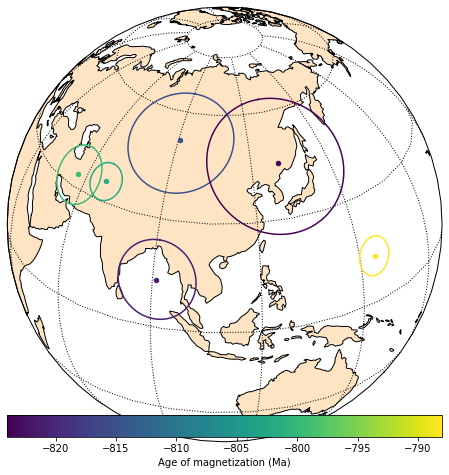

In [15]:
map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

# change the range of the colorbar to be between these two values
# this is to ensure a good dynamic range ~800 Ma where there are lots of poles
# then set the youngest pole to be at the limit of the colorbar
colorbar_max = np.max(SChina_compiled['age'])
colorbar_min = np.min(SChina_compiled['age'])

cmap = matplotlib.cm.get_cmap('viridis')
color_inds = -(SChina_compiled['age'].values.astype(np.float)-colorbar_max)/(colorbar_max-colorbar_min)
for i in range(len(color_inds)):
    if color_inds[i]>1:
        color_inds[i] = 1
colors = cmap(color_inds)

for i in range(len(SChina_compiled.index)):
    ipmag.plot_pole(map_ax,
                    SChina_compiled['lon'][i],SChina_compiled['lat'][i],SChina_compiled['a95'][i],
                    color=colors[i], edgecolor=colors[i])
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')

## India

In [16]:
India_compiled = pd.DataFrame(columns=compiled_cols)

j = 0

### Malani Dikes

In [17]:
India_compiled.loc[j, 'age'] = 759
India_compiled.loc[j, 'age upper (reported)'] = 759 - 12
India_compiled.loc[j, 'age lower (reported)'] = 759 + 12
India_compiled.loc[j, 'age upper (estimate)'] = 752 - 18
India_compiled.loc[j, 'age lower (estimate)'] = 759 + 12
India_compiled.loc[j, 'lat'] = 69.4
India_compiled.loc[j, 'lon'] = 75.7
India_compiled.loc[j, 'a95'] = 6.5
India_compiled.loc[j, 'rock'] = 'Malani Dikes - mafic dikes'
India_compiled.loc[j, 'f'] = 0
India_compiled.loc[j, 'pole reference'] = 'Meert et al. (2013)'
India_compiled.loc[j, 'age reference'] = 'Meert et al. (2013) - LA on dike'
India_compiled.loc[j, 'grade'] = 'A - baked contact test'
India_compiled.loc[j, 'note'] = 'All zircons are off concordia - 759 +/- 12 is the intercept age, and 752 +/- 18 is the 207Pb/206Pb age.'
j = j + 1

### Compiled

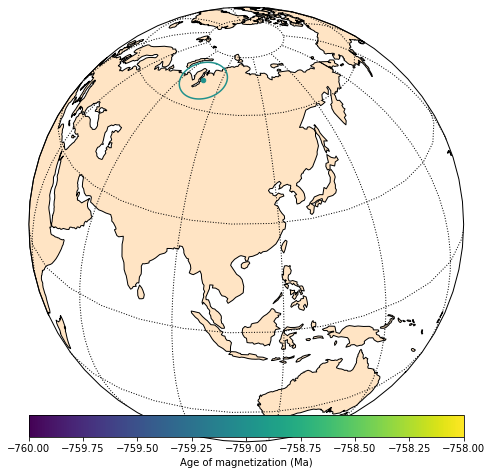

In [18]:
map_ax = ipmag.make_orthographic_map(figsize=(8,8), central_longitude=110, central_latitude=30, land_color='bisque')

# change the range of the colorbar to be between these two values
# this is to ensure a good dynamic range ~800 Ma where there are lots of poles
# then set the youngest pole to be at the limit of the colorbar
colorbar_max = np.max(India_compiled['age']+1)
colorbar_min = np.min(India_compiled['age']-1)

cmap = matplotlib.cm.get_cmap('viridis')
color_inds = -(India_compiled['age'].values.astype(np.float)-colorbar_max)/(colorbar_max-colorbar_min)
for i in range(len(color_inds)):
    if color_inds[i]>1:
        color_inds[i] = 1
colors = cmap(color_inds)

for i in range(len(India_compiled.index)):
    ipmag.plot_pole(map_ax,
                    India_compiled['lon'][i],India_compiled['lat'][i],India_compiled['a95'][i],
                    color=colors[i], edgecolor=colors[i])
    
# add the colorbar (note that this colorbar is not tied to the scatter above - it is manually created)
norm = matplotlib.colors.Normalize(vmin=-colorbar_min, vmax=-colorbar_max)
cax = inset_axes(plt.gca(), width='100%', height='5%', loc=8)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cbar.set_label('Age of magnetization (Ma)')

## Australia

In [19]:
Australia_compiled = pd.DataFrame(columns=compiled_cols)

j = 0